In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret,clickhouse_event_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    elif user == clickhouse_event_secret['user']:
            db_name = clickhouse_event_secret['db_name'] 
            password = clickhouse_event_secret['password']
            host = clickhouse_event_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [179]:
query = f'''SELECT t1.*,t2.device AS device,t2.first_prolong_date::date AS first_prolong_date,reg_source
             FROM datamarts.watchtime_by_day as t1
             LEFT JOIN datamarts.marketing_dash AS t2 ON t1.profile_id = t2.profile_id
             WHERE date BETWEEN '2025-03-01' AND '2025-06-01'
         '''

df = execute(query,user='kmekhtiev')

df['date'] = df['date'].astype('datetime64[ns]')
df['first_prolong_date'] = df['first_prolong_date'].astype('datetime64[ns]')

Время выполнения функции: 18.6238 секунд



# Смотрение по платформам 

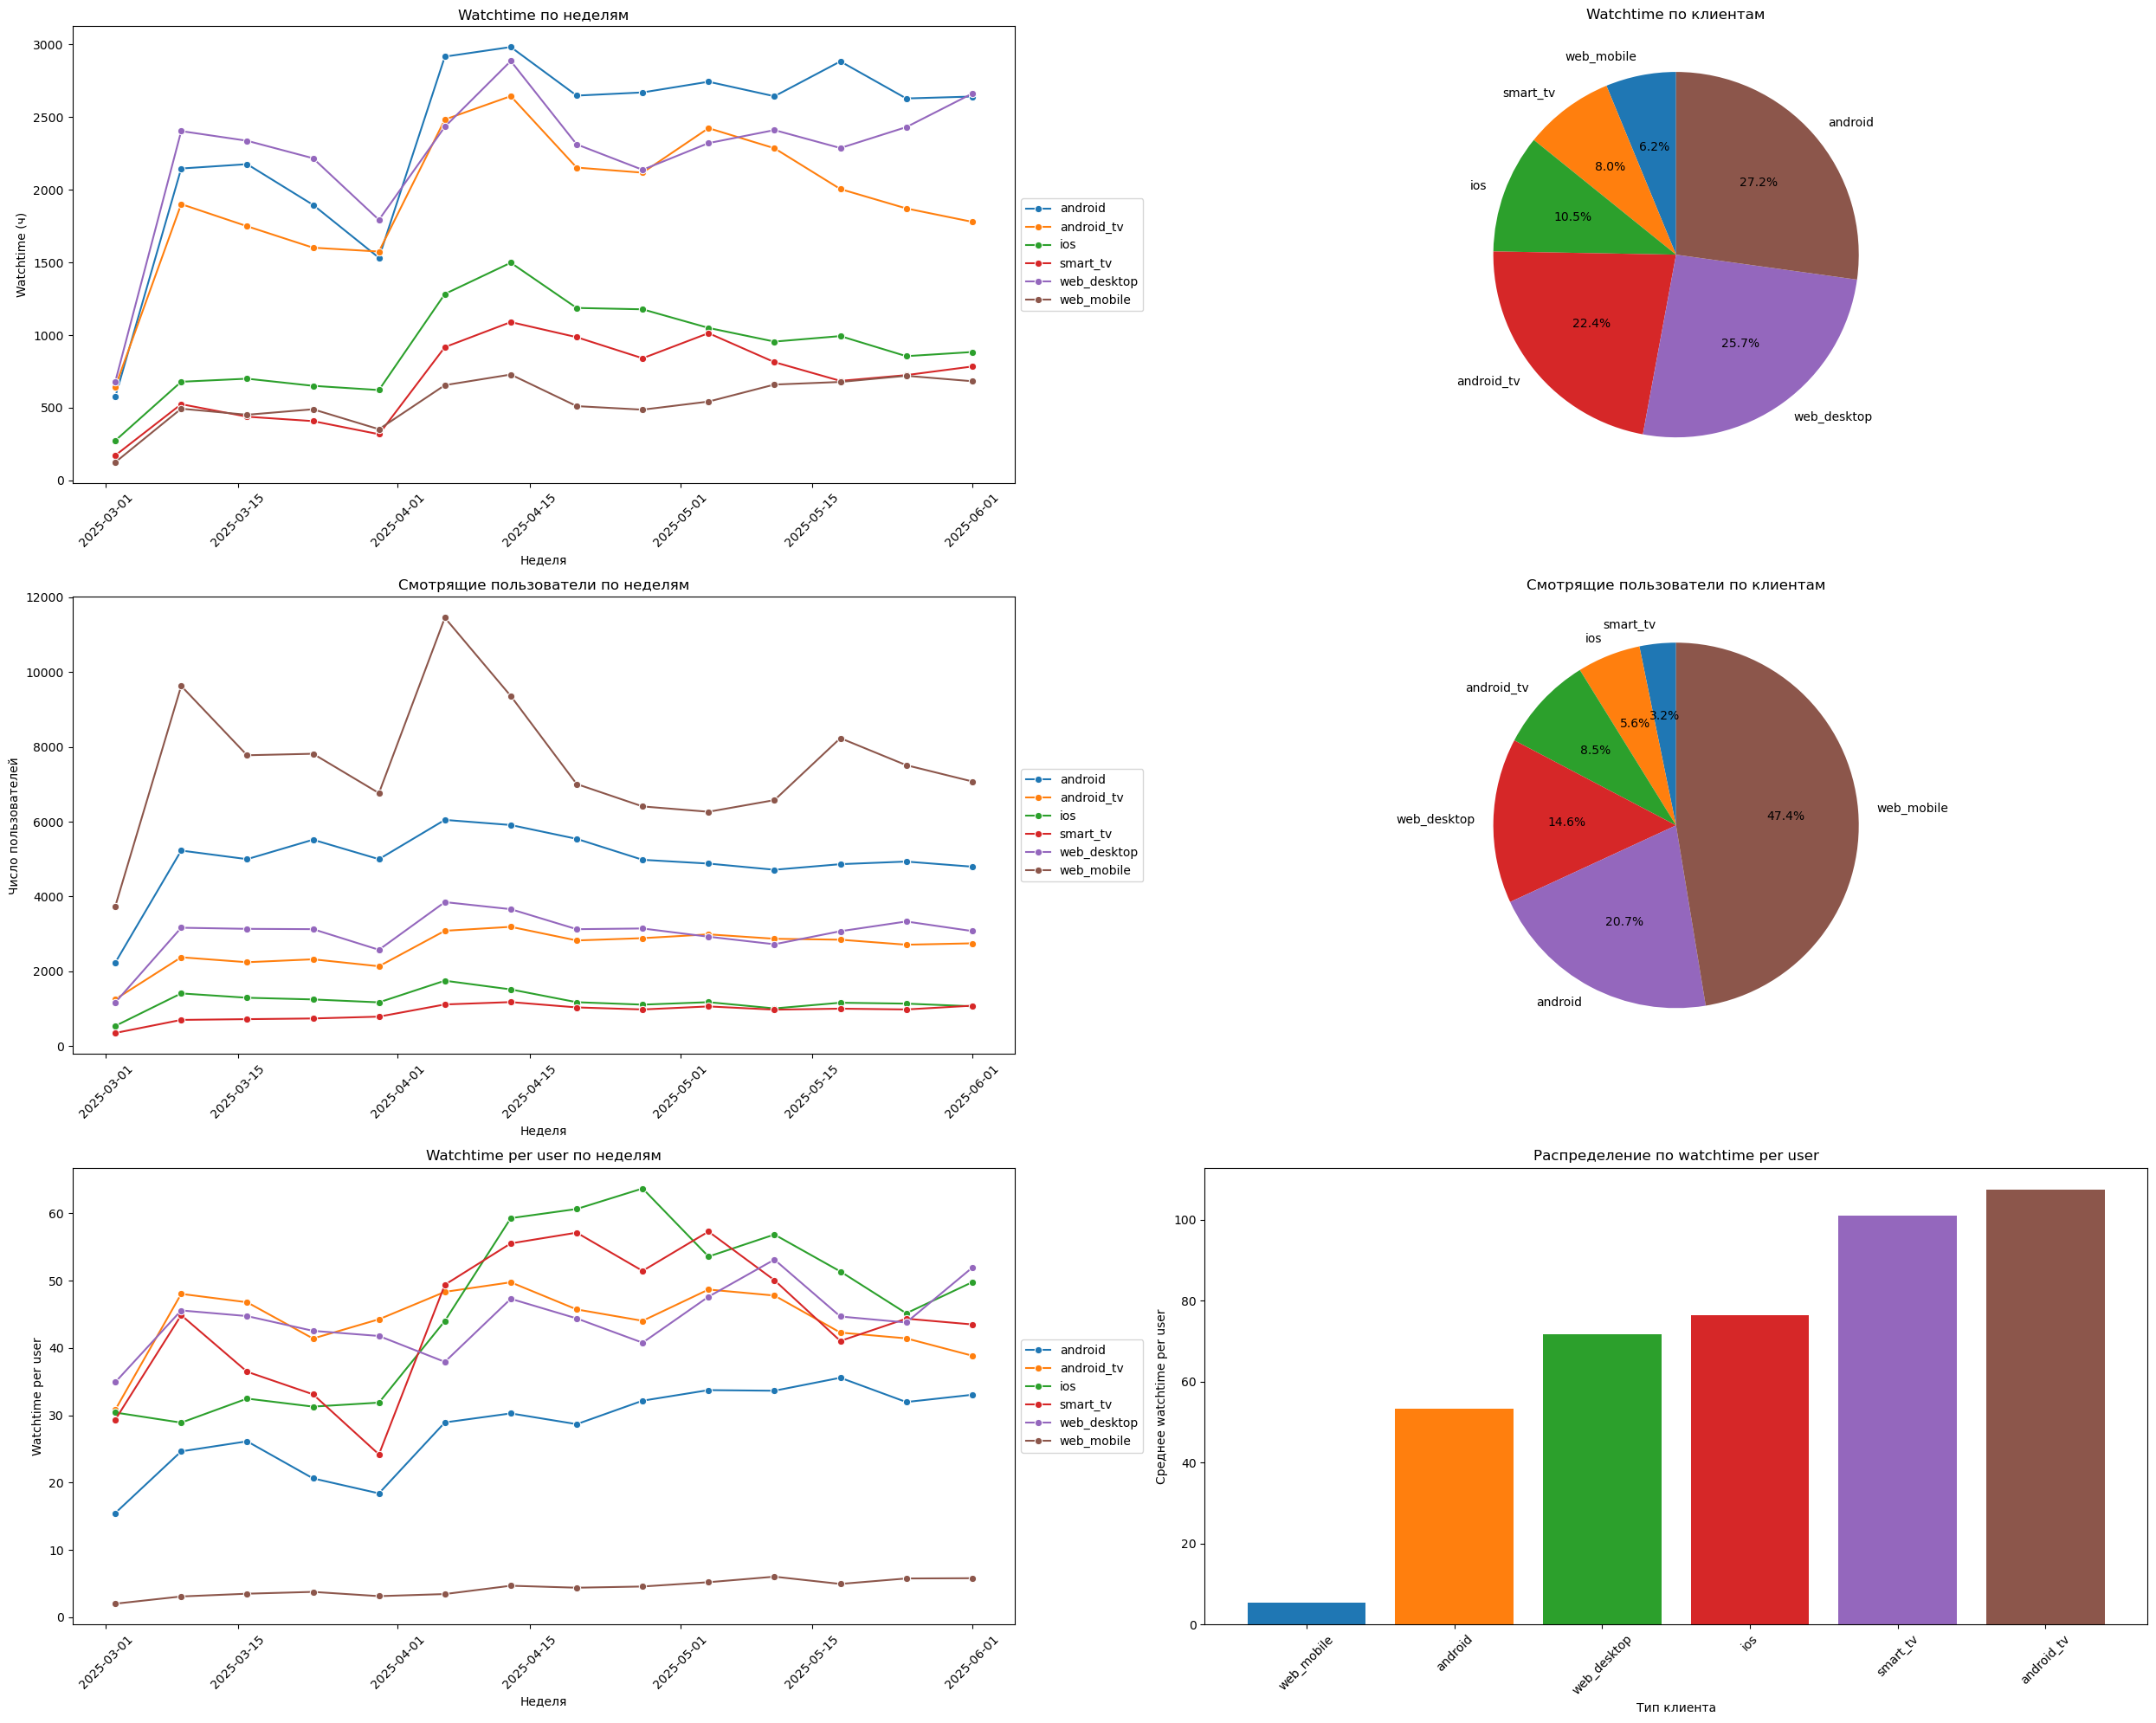

In [4]:
# Группировка по неделям
df_agg = df.groupby([pd.Grouper(key='date', freq='W'), 'client_type']).agg({'watchtime':'sum','profile_id':'nunique'}).reset_index()
df_agg['watchtime_per_user'] = df_agg['watchtime'] / df_agg['profile_id'] / 60
df_agg['watchtime'] = df_agg['watchtime'] / 3600

# Группировка по типу клиента
df_agg2 = df.groupby('client_type').agg({'watchtime':'sum','profile_id':'nunique'}).reset_index()
df_agg2['watchtime_per_user'] = df_agg2['watchtime'] / df_agg2['profile_id'] / 60
df_agg2_sorted = df_agg2.sort_values(by='watchtime', ascending=True)

# Группировка по последнему уровню (по числу уникальных пользователей)
df_agg3_sorted = df_agg2.sort_values(by='profile_id', ascending=True)

# Группировка по watchtime per user
df_agg4_sorted = df_agg2.sort_values(by='watchtime_per_user', ascending=True)

# Создаем 2 строки по 3 графика (всего 6 графиков)
fig, axs = plt.subplots(3, 2, figsize=(25, 20))
axs = axs.flatten()  # чтобы обращаться как к списку по индексам

# 1. График 1: Watchtime по неделям
sns.lineplot(data=df_agg, x='date', y='watchtime', hue='client_type', ax=axs[0], marker='o')
axs[0].set_title('Watchtime по неделям')
axs[0].set_xlabel('Неделя')
axs[0].set_ylabel('Watchtime (ч)')
axs[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
axs[0].tick_params(axis='x', rotation=45)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 2. График 2: Распределение общего времени по клиентам
axs[1].pie(
    df_agg2_sorted['watchtime'],
    labels=df_agg2_sorted['client_type'],
    autopct='%1.1f%%',
    startangle=90
)
axs[1].set_title('Watchtime по клиентам')

# 3. График 3: Количество уникальных пользователей по неделям
sns.lineplot(data=df_agg, x='date', y='profile_id', hue='client_type', ax=axs[2], marker='o')
axs[2].set_title('Смотрящие пользователи по неделям')
axs[2].set_xlabel('Неделя')
axs[2].set_ylabel('Число пользователей')
axs[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
axs[2].tick_params(axis='x', rotation=45)
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 4. График 4: Распределение пользователей по клиентам
axs[3].pie(
    df_agg3_sorted['profile_id'],
    labels=df_agg3_sorted['client_type'],
    autopct='%1.1f%%',
    startangle=90
)
axs[3].set_title('Смотрящие пользователи по клиентам')

# 5. График 5: Watchtime на пользователя (по неделям)
sns.lineplot(data=df_agg, x='date', y='watchtime_per_user', hue='client_type', ax=axs[4], marker='o')
axs[4].set_title('Watchtime per user по неделям')
axs[4].set_xlabel('Неделя')
axs[4].set_ylabel('Watchtime per user')
axs[4].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
axs[4].tick_params(axis='x', rotation=45)
axs[4].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# 6. График 6: Распределение пользователей по клиентам (по watchtime per user)
colors = plt.cm.tab10.colors  # Используем палитру из 10 цветов
axs[5].bar(
    df_agg4_sorted['client_type'],
    df_agg4_sorted['watchtime_per_user'],
    color=colors[:len(df_agg4_sorted)]  # применяем нужное количество цветов
)
axs[5].set_xlabel('Тип клиента')
axs[5].set_ylabel('Среднее watchtime per user')
axs[5].set_title('Распределение по watchtime per user')
axs[5].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [341]:
df_agg = df.groupby([pd.Grouper(key='date', freq='M'), 'client_type']).agg({'watchtime':'sum','profile_id':'nunique'}).reset_index()
df_agg['watchtime_per_user'] = df_agg['watchtime'] / df_agg['profile_id'] / 60
df_agg['watchtime'] = df_agg['watchtime'] / 3600



pivot_df = pd.pivot(df_agg,columns='date',index='client_type',values='profile_id')

row_sums = pivot_df.sum(axis=1)
pivot_df['Total'] = row_sums

# Итоговая сумма по столбцам (по каждому дню)
col_sums = pivot_df.sum(axis=0)
pivot_df.loc['Total'] = col_sums


pivot_df

date,2025-03-31 00:00:00,2025-04-30 00:00:00,2025-05-31 00:00:00,2025-06-30 00:00:00,Total
client_type,,,,,
android,16349,16621,14705,995,48670
android_tv,6332,7195,7101,954,21582
ios,4372,4226,3529,247,12374
smart_tv,2177,2762,2779,325,8043
web_desktop,10202,10983,9429,708,31322
web_mobile,33264,31057,28039,1142,93502
Total,72696,72844,65582,4371,215493


In [333]:
pivot_df = pd.pivot(df_client_agg2,columns='date',index='client_type',values='profile_id')

row_sums = pivot_df.sum(axis=1)
pivot_df['Total'] = row_sums

# Итоговая сумма по столбцам (по каждому дню)
col_sums = pivot_df.sum(axis=0)
pivot_df.loc['Total'] = col_sums


pivot_df

,date,client_type,watchtime,profile_id,watchtime_per_user
0,2025-03-31,android,8585.430556,16349,31.508094
1,2025-03-31,android_tv,7642.948056,6332,72.422123
2,2025-03-31,ios,3013.875833,4372,41.361516
3,2025-03-31,smart_tv,1920.330000,2177,52.925953
4,2025-03-31,web_desktop,9638.618611,10202,56.686642
5,2025-03-31,web_mobile,1959.058889,33264,3.533656
6,2025-04-30,android,12063.743889,16621,43.548802
7,2025-04-30,android_tv,10119.626111,7195,84.388821
8,2025-04-30,ios,5552.485000,4226,78.833199
9,2025-04-30,smart_tv,4121.295833,2762,89.528512


# Привлечение по платформам

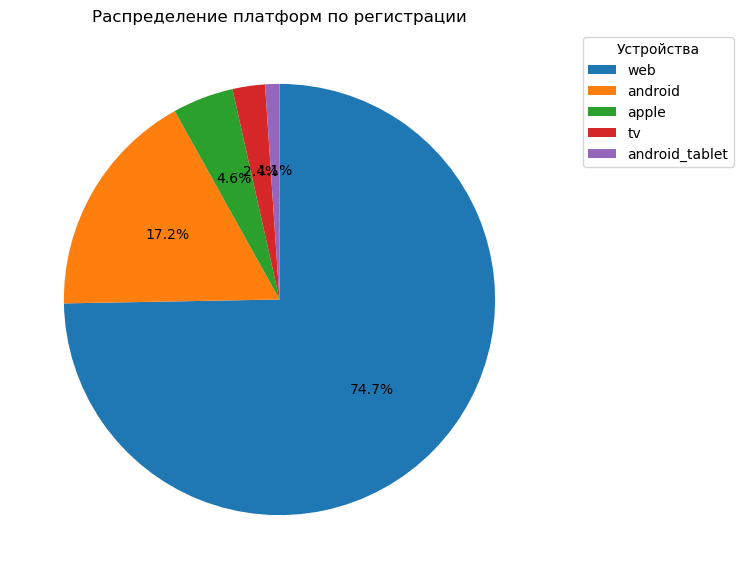

In [121]:
df_reg_device = df.groupby('device',as_index=False)['profile_id'].nunique()
df_reg_device_sorted = df_reg_device.sort_values(by='profile_id',ascending = False)

plt.figure(figsize = (8,7))
plt.pie(
    df_reg_device_sorted['profile_id'],
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

plt.legend(
    df_reg_device_sorted['device'],
    title='Устройства',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title('Распределение платформ по регистрации')
plt.show()

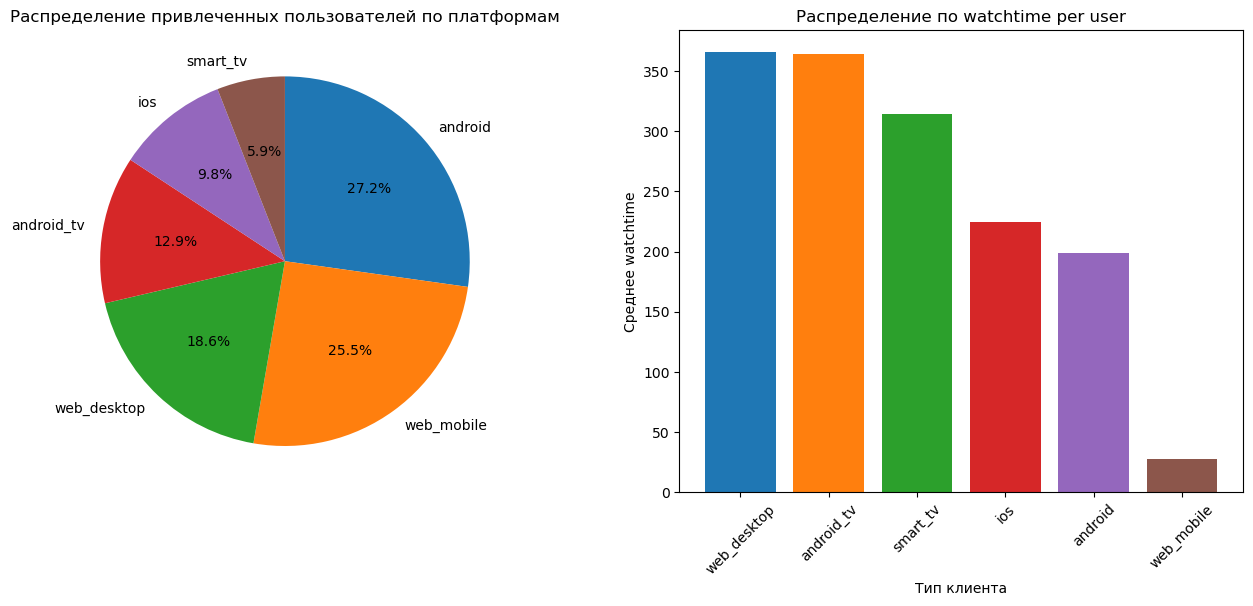

In [135]:
df_client = df[(df['first_prolong_date']!= '1970-01-01') & (df['date']>=df['first_prolong_date'])].groupby(['profile_id','client_type']).agg({'watchtime':'sum'}).reset_index()
df_client['sum_watchtime_by_user'] = df_client.groupby('profile_id')['watchtime'].transform('sum')
df_client['watchtime_frac'] = df_client['watchtime'] / df_client['sum_watchtime_by_user']
df_client['max_frac'] = df_client.groupby('profile_id')['watchtime_frac'].transform('max')

df_client_agg = df_client[df_client['max_frac'] == df_client['watchtime_frac']]

df_client_agg2 = df_client_agg.groupby('client_type').agg({'profile_id':'nunique'}).reset_index()
df_client_agg2_sorted = df_client_agg2.sort_values(by='profile_id',ascending = False)


fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs = axs.flatten()  # чтобы обращаться как к списку по индексам

axs[0].pie(
    df_client_agg2_sorted['profile_id'],
    labels=df_client_agg2_sorted['client_type'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

axs[0].set_title('Распределение привлеченных пользователей по платформам')


df_client_agg3 = df_client_agg.groupby('client_type').agg({'watchtime':'mean'}).reset_index()
df_client_agg3['watchtime'] = df_client_agg3['watchtime']/60
df_client_agg3_sorted = df_client_agg3.sort_values(by='watchtime',ascending = False)

colors = plt.cm.tab10.colors  # Используем палитру из 10 цветов
axs[1].bar(
    df_client_agg3_sorted['client_type'],
    df_client_agg3_sorted['watchtime'],
    color=colors[:len(df_client_agg3_sorted)]  # применяем нужное количество цветов
)
axs[1].set_xlabel('Тип клиента')
axs[1].set_ylabel('Среднее watchtime')
axs[1].set_title('Распределение по watchtime per user')
axs[1].tick_params(axis='x', rotation=45)


plt.show()

In [329]:
# По месяцам посмотреть 

df_client = df[(df['first_prolong_date'] != '1970-01-01') & (df['date'] >= df['first_prolong_date'])] \
            .groupby([pd.Grouper(key='date', freq='M'), 'profile_id', 'client_type']) \
            .agg({'watchtime':'sum'}) \
            .reset_index()
df_client['sum_watchtime_by_user'] = df_client.groupby(['date','profile_id'])['watchtime'].transform('sum')
df_client['watchtime_frac'] = df_client['watchtime'] / df_client['sum_watchtime_by_user']
df_client['max_frac'] = df_client.groupby('profile_id')['watchtime_frac'].transform('max')

df_client_agg = df_client[df_client['max_frac'] == df_client['watchtime_frac']]

df_client_agg2 = df_client_agg.groupby(['date','client_type']).agg({'profile_id':'nunique'}).reset_index()
df_client_agg2_sorted = df_client_agg2.sort_values(by='profile_id',ascending = False)


pivot_df = pd.pivot(df_client_agg2,columns='date',index='client_type',values='profile_id')

row_sums = pivot_df.sum(axis=1)
pivot_df['Total'] = row_sums

# Итоговая сумма по столбцам (по каждому дню)
col_sums = pivot_df.sum(axis=0)
pivot_df.loc['Total'] = col_sums


pivot_df

date,2025-03-31 00:00:00,2025-04-30 00:00:00,2025-05-31 00:00:00,2025-06-30 00:00:00,Total
client_type,,,,,
android,956,1045,1143,142,3286
android_tv,332,412,484,159,1387
ios,334,365,342,54,1095
smart_tv,127,195,271,55,648
web_desktop,621,706,759,108,2194
web_mobile,726,755,956,59,2496
Total,3096,3478,3955,577,11106


In [203]:
df_client_agg_merge = pd.merge(df_client_agg,df[['profile_id','device','reg_source']],how='left',on='profile_id')

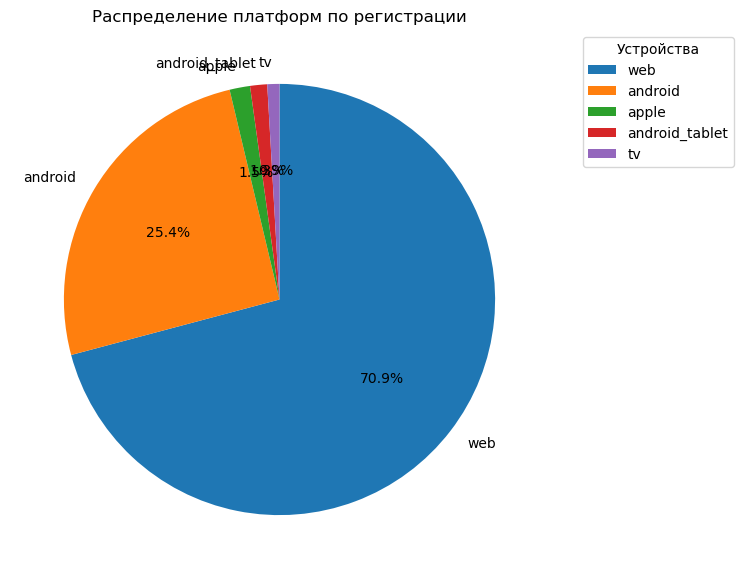

In [185]:
df_agg_sub = df_client_agg_merge[df_client_agg_merge['client_type'].isin(['android','android_tv'])].groupby('device')['profile_id'].nunique().reset_index()
df_agg_sub_sorted = df_agg_sub.sort_values(by='profile_id', ascending = False)

plt.figure(figsize = (8,7))
plt.pie(
    df_agg_sub_sorted['profile_id'],
    labels=df_agg_sub_sorted['device'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

plt.legend(
    df_agg_sub_sorted['device'],
    title='Устройства',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title('Распределение платформ по регистрации')
plt.show()

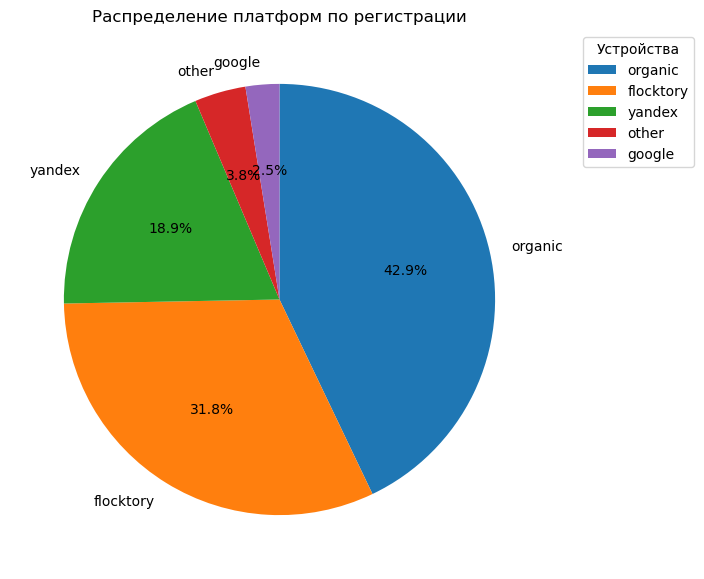

In [255]:
df_client_agg_merge['reg_source2'] = df_client_agg_merge['reg_source'].apply(
    lambda x: 'flocktory' if x == 'flocktory' else
              'yandex' if x == 'yandex' else
              'organic' if x == 'none' else
              'google' if x == 'google-play' else
              'other'
)

t = df_client_agg_merge[df_client_agg_merge['client_type'].isin(['web_desktop','web_mobile'])].groupby('reg_source2')['profile_id'].nunique().reset_index()
t_sorted = t.sort_values(by='profile_id', ascending = False)


plt.figure(figsize = (8,7))
plt.pie(
    t_sorted['profile_id'],
    labels=t_sorted['reg_source2'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

plt.legend(
    t_sorted['reg_source2'],
    title='Устройства',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title('Распределение платформ по регистрации')
plt.show()

In [284]:
df_client_agg_merge

,profile_id,client_type,watchtime,sum_watchtime_by_user,watchtime_frac,max_frac,device,reg_source,reп_source2,reg_source2
0,0003a49d-bdf0-47f5-a324-8085d9a65737,web_mobile,10,11,0.909091,0.909091,android,none,organic,organic
1,0003a49d-bdf0-47f5-a324-8085d9a65737,web_mobile,10,11,0.909091,0.909091,android,none,organic,organic
2,0003a49d-bdf0-47f5-a324-8085d9a65737,web_mobile,10,11,0.909091,0.909091,android,none,organic,organic
3,0003a49d-bdf0-47f5-a324-8085d9a65737,web_mobile,10,11,0.909091,0.909091,android,none,organic,organic
4,0003a49d-bdf0-47f5-a324-8085d9a65737,web_mobile,10,11,0.909091,0.909091,android,none,organic,organic
...,...,...,...,...,...,...,...,...,...,...
182117,fff59cad-e4f2-4686-b8e5-bcea16038c44,smart_tv,420,423,0.992908,0.992908,android,google-play,google,google
182118,fff59cad-e4f2-4686-b8e5-bcea16038c44,smart_tv,420,423,0.992908,0.992908,android,google-play,google,google
182119,fff59cad-e4f2-4686-b8e5-bcea16038c44,smart_tv,420,423,0.992908,0.992908,android,google-play,google,google
182120,fff59cad-e4f2-4686-b8e5-bcea16038c44,smart_tv,420,423,0.992908,0.992908,android,google-play,google,google


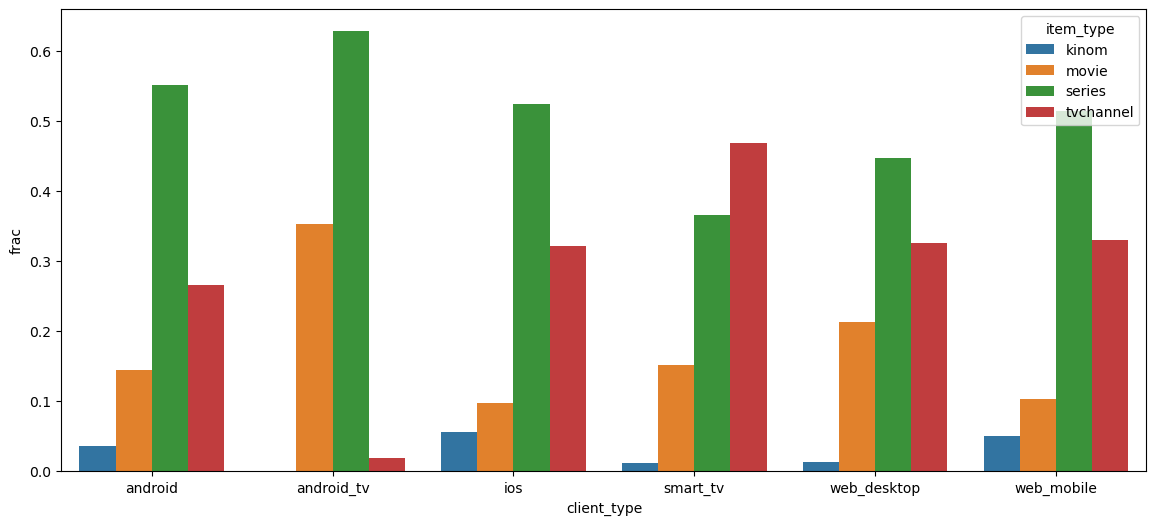

In [272]:
r = df.groupby(['client_type','item_type']).agg({'watchtime':'sum','profile_id':'nunique'}).reset_index()
r = r[r['item_type'].isin(['kinom','movie','series','tvchannel'])]

r['watchtime_sum'] = r.groupby('client_type')['watchtime'].transform('sum')

r['frac'] = r['watchtime'] / r['watchtime_sum']


plt.figure(figsize = (14,6))

sns.barplot(data=r,x='client_type',y='frac',hue = 'item_type')
plt.show()

In [282]:
r.groupby('item_type')['frac'].mean()

item_type
kinom        0.028258
movie        0.177472
series       0.505488
tvchannel    0.288782
Name: frac, dtype: float64